In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import importlib, import_ipynb
import data_clean_order_combined as data
import tensorflow as tf
from tensorflow.data import experimental
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [5]:
%store -r rand_shuffled_text
%store -r ordered_super_alpha_text
%store -r ordered_class_alpha_text
%store -r ordered_sem_clusters_desc_text
%store -r ordered_sem_clusters_asc_text
%store -r ordered_sem_clusters_shuffled_per_superclass_text
%store -r test_df

In [6]:
# Experimental data orderings on headlines TRAIN EXAMPLES
XB_train = rand_shuffled_text['cleaned_headline']
X1_train = ordered_super_alpha_text['cleaned_headline']
X2_train = ordered_class_alpha_text['cleaned_headline']
X3_train = ordered_sem_clusters_desc_text['cleaned_headline']
X4_train = ordered_sem_clusters_asc_text['cleaned_headline']
X5_train = ordered_sem_clusters_shuffled_per_superclass_text['cleaned_headline']

# TRAIN LABELS
YB_train = rand_shuffled_text['class']
Y1_train = ordered_super_alpha_text['class']
Y2_train = ordered_class_alpha_text['class']
Y3_train = ordered_sem_clusters_desc_text['class']
Y4_train = ordered_sem_clusters_asc_text['class']
Y5_train = ordered_sem_clusters_shuffled_per_superclass_text['class']

# TEST EXAMPLES
X_test = test_df['cleaned_headline']
Y_test = test_df['class']

## Tokenization and Vectorization


### One-hot encoding and indexing of train and test data

In [9]:
# TEST DATA

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_test = encoder.fit_transform(Y_test)
print("shape of input data: ", X_test.shape)
print("shape of target variable: ", Y_test.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_test) # build the word index
# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test) # converts strinfs into integer lists
test_padseq = pad_sequences(test_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 150000000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence 
Y_test = to_categorical(Y_test, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (41905,)
shape of target variable:  (41905,)
Length of word index: 77553


In [10]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

# BASELINE ORDER - RAND SHUFFLED

In [11]:
# BASELINE TRAIN DATA
X_train = XB_train
Y_train = YB_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 217923


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [12]:
model2B = Sequential()
model2B.add(Embedding(total_words, 100, input_length=maxlen))
model2B.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2B.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2B.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2B.add(Conv1D(72, 3, activation='relu'))
model2B.add(MaxPooling1D(2))
model2B.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2B.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2B.add(Dropout(0.2))
model2B.add(Dense(42, activation='softmax'))
model2B.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           21792300  
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 18, 72)            27720     
                                                        

In [13]:
model2B.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history2B = model2B.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1048/1048 [==============================] - 404s 356ms/step - loss: 2.9606 - accuracy: 0.3330 - val_loss: 2.2560 - val_accuracy: 0.4388
Epoch 2/15
1048/1048 [==============================] - 386s 368ms/step - loss: 2.0538 - accuracy: 0.4880 - val_loss: 1.9629 - val_accuracy: 0.5094
Epoch 3/15
1048/1048 [==============================] - 336s 321ms/step - loss: 1.7717 - accuracy: 0.5529 - val_loss: 1.9196 - val_accuracy: 0.5203
Epoch 4/15
1048/1048 [==============================] - 337s 322ms/step - loss: 1.5791 - accuracy: 0.5984 - val_loss: 1.8993 - val_accuracy: 0.5317
Epoch 5/15
1048/1048 [==============================] - 388s 370ms/step - loss: 1.4176 - accuracy: 0.6392 - val_loss: 1.9058 - val_accuracy: 0.5328
Epoch 6/15
1048/1048 [==============================] - 387s 369ms/step - loss: 1.2712 - accuracy: 0.6777 - val_loss: 1.9255 - val_accuracy: 0.5342
Epoch 7/15
1048/1048 [==============================] - 381s 363ms/step - loss: 1.1238 - accuracy: 0.7168 - val_

In [ ]:
# evalute the model
test_loss, test_acc = model2B.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history2B)

Y_pred = model2B.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 1

In [6]:
# ORDER 1 TRAIN DATA
X_train = X1_train
Y_train = Y1_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53645


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [7]:
model1 = Sequential()
model1.add(Embedding(total_words, 100, input_length=maxlen))
model1.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model1.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model1.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model1.add(Conv1D(72, 3, activation='relu'))
model1.add(MaxPooling1D(2))
model1.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model1.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model1.add(Dropout(0.2))
model1.add(Dense(42, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           5364500   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 18, 72)            27720     
                                                        

In [8]:
model1.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history1 = model1.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1310/1310 [==============================] - 384s 263ms/step - loss: 1.6671 - accuracy: 0.5452
Epoch 2/15
1310/1310 [==============================] - 309s 236ms/step - loss: 1.1044 - accuracy: 0.6694
Epoch 3/15
1310/1310 [==============================] - 310s 236ms/step - loss: 1.0005 - accuracy: 0.7041
Epoch 4/15
1310/1310 [==============================] - 301s 230ms/step - loss: 0.9293 - accuracy: 0.7279
Epoch 5/15
1310/1310 [==============================] - 303s 231ms/step - loss: 0.8714 - accuracy: 0.7470
Epoch 6/15
1310/1310 [==============================] - 317s 242ms/step - loss: 0.8183 - accuracy: 0.7638
Epoch 7/15
1310/1310 [==============================] - 331s 253ms/step - loss: 0.7736 - accuracy: 0.7801
Epoch 8/15
1310/1310 [==============================] - 350s 267ms/step - loss: 0.7349 - accuracy: 0.7930
Epoch 9/15
1310/1310 [==============================] - 346s 264ms/step - loss: 0.7009 - accuracy: 0.8040
Epoch 10/15
1310/1310 [=======================

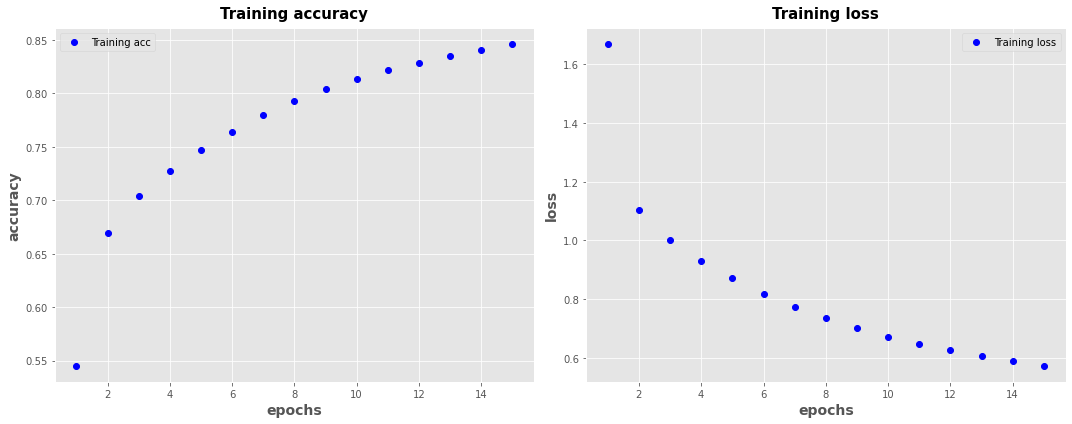

In [10]:
# evalute the model
test_loss, test_acc = model1.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history1)

Y_pred = model1.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

# EXPERIMENT ORDER 2

In [10]:
# ORDER 2 TRAIN DATA
X_train = X2_train
Y_train = Y2_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53645


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [11]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(42, activation='softmax'))
model2.summary()

KeyboardInterrupt: 

In [ ]:
model2.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1310/1310 [==============================] - 370s 260ms/step - loss: 1.7140 - accuracy: 0.5270
Epoch 2/15
1310/1310 [==============================] - 348s 266ms/step - loss: 1.1365 - accuracy: 0.6607
Epoch 3/15
1310/1310 [==============================] - 341s 260ms/step - loss: 1.0115 - accuracy: 0.7009
Epoch 4/15
1310/1310 [==============================] - 333s 254ms/step - loss: 0.9373 - accuracy: 0.7258
Epoch 5/15
1310/1310 [==============================] - 331s 253ms/step - loss: 0.8782 - accuracy: 0.7447
Epoch 6/15
1310/1310 [==============================] - 338s 258ms/step - loss: 0.8296 - accuracy: 0.7610
Epoch 7/15
1310/1310 [==============================] - 336s 256ms/step - loss: 0.7845 - accuracy: 0.7773
Epoch 8/15
1310/1310 [==============================] - 336s 257ms/step - loss: 0.7475 - accuracy: 0.7897
Epoch 9/15
1310/1310 [==============================] - 351s 268ms/step - loss: 0.7126 - accuracy: 0.8008
Epoch 10/15
1310/1310 [=======================

In [10]:
# evalute the model
test_loss, test_acc = model2.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history2)

Y_pred = model2.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

NameError: name 'plot_loss_accuracy' is not defined

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 3

In [12]:
# ORDER 3 TRAIN DATA
X_train = X3_train
Y_train = Y3_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53645


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

In [13]:
model3 = Sequential()
model3.add(Embedding(total_words, 100, input_length=maxlen))
model3.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model3.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model3.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model3.add(Conv1D(72, 3, activation='relu'))
model3.add(MaxPooling1D(2))
model3.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model3.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model3.add(Dropout(0.2))
model3.add(Dense(42, activation='softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           5364500   
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 20, 128)          24704     
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [15]:
model3.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history3 = model3.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1310/1310 [==============================] - 367s 260ms/step - loss: 1.7189 - accuracy: 0.5256
Epoch 2/15
1310/1310 [==============================] - 336s 257ms/step - loss: 1.1329 - accuracy: 0.6606
Epoch 3/15
1310/1310 [==============================] - 332s 253ms/step - loss: 1.0089 - accuracy: 0.7002
Epoch 4/15
1310/1310 [==============================] - 366s 279ms/step - loss: 0.9376 - accuracy: 0.7250
Epoch 5/15
1310/1310 [==============================] - 340s 260ms/step - loss: 0.8816 - accuracy: 0.7434
Epoch 6/15
1310/1310 [==============================] - 352s 269ms/step - loss: 0.8314 - accuracy: 0.7610
Epoch 7/15
1310/1310 [==============================] - 343s 262ms/step - loss: 0.7882 - accuracy: 0.7753
Epoch 8/15
1310/1310 [==============================] - 337s 257ms/step - loss: 0.7492 - accuracy: 0.7888
Epoch 9/15
1310/1310 [==============================] - 339s 259ms/step - loss: 0.7171 - accuracy: 0.8002
Epoch 10/15
1310/1310 [=======================

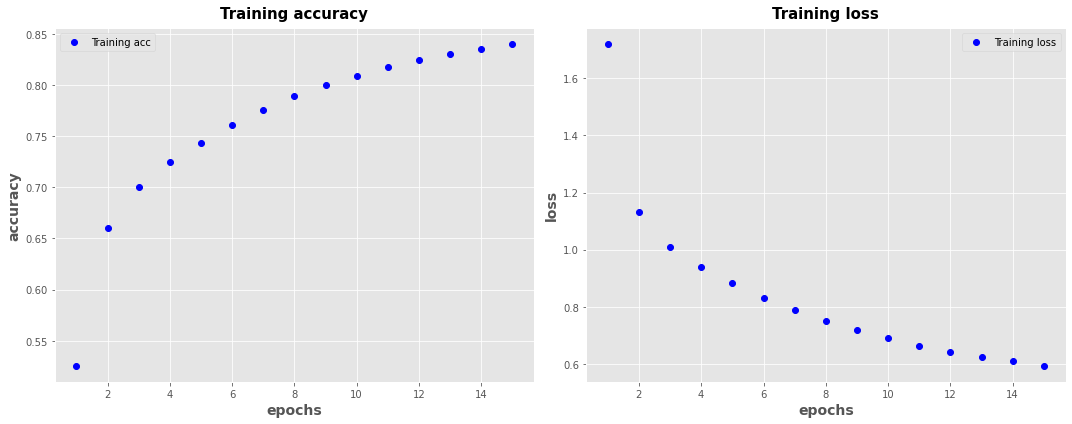

In [16]:
# evalute the model
test_loss, test_acc = model3.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history3)

Y_pred = model3.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 4

In [17]:
# ORDER 4 TRAIN DATA
X_train = X4_train
Y_train = Y4_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

shape of input data:  (167616,)
shape of target variable:  (167616,)
Length of word index: 53645


### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer


In [18]:
model4 = Sequential()
model4.add(Embedding(total_words, 100, input_length=maxlen))
model4.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model4.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model4.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model4.add(Conv1D(72, 3, activation='relu'))
model4.add(MaxPooling1D(2))
model4.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model4.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model4.add(Dropout(0.2))
model4.add(Dense(42, activation='softmax'))
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 100)           5364500   
                                                                 
 bidirectional_8 (Bidirectio  (None, 20, 128)          84480     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 20, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 20, 128)          24704     
 onal)                                                           
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 72)            27720     
                                                      

In [20]:
model4.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history4 = model4.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

Epoch 1/15
1310/1310 [==============================] - 406s 288ms/step - loss: 1.6588 - accuracy: 0.5460
Epoch 2/15
1310/1310 [==============================] - 365s 279ms/step - loss: 1.1147 - accuracy: 0.6666
Epoch 3/15
1310/1310 [==============================] - 337s 257ms/step - loss: 1.0094 - accuracy: 0.7006
Epoch 4/15
1310/1310 [==============================] - 368s 281ms/step - loss: 0.9364 - accuracy: 0.7246
Epoch 5/15
1310/1310 [==============================] - 383s 292ms/step - loss: 0.8781 - accuracy: 0.7435
Epoch 6/15
1310/1310 [==============================] - 369s 282ms/step - loss: 0.8300 - accuracy: 0.7604
Epoch 7/15
1310/1310 [==============================] - 371s 284ms/step - loss: 0.7865 - accuracy: 0.7763
Epoch 8/15
1310/1310 [==============================] - 395s 301ms/step - loss: 0.7505 - accuracy: 0.7870
Epoch 9/15
1310/1310 [==============================] - 366s 279ms/step - loss: 0.7171 - accuracy: 0.7990
Epoch 10/15
1310/1310 [=======================

In [ ]:
# evalute the model
test_loss, test_acc = model4.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history4)

Y_pred = model4.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time:

# EXPERIMENT ORDER 5

In [ ]:
# ORDER 5 TRAIN DATA
X_train = X5_train
Y_train = Y5_train

# one hot encoding using keras tokenizer and pad sequencing
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("shape of input data: ", X_train.shape)
print("shape of target variable: ", Y_train.shape)

tokenizer = Tokenizer(num_words=1000000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

word_index = tokenizer.word_index
max_words = 15000000  # total number of words to consider in embedding layer
total_words = len(word_index) + 1000
maxlen = 20 # max length of sequence 
Y_train = to_categorical(Y_train, num_classes=42)
print("Length of word index:", total_words)

### Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer


In [ ]:
model5 = Sequential()
model5.add(Embedding(total_words, 100, input_length=maxlen))
model5.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model5.add(Conv1D(72, 3, activation='relu'))
model5.add(MaxPooling1D(2))
model5.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model5.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model5.add(Dropout(0.2))
model5.add(Dense(42, activation='softmax'))
model5.summary()

In [ ]:
model5.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
#SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]
callback_list = [earlystopping]

# fit model to the data
history5 = model5.fit(train_padseq, Y_train, 
                   batch_size=128, 
                    epochs=15,
                    validation_split=0.2
                   )

In [ ]:
# evalute the model
test_loss, test_acc = model5.evaluate(test_padseq, Y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)

plot_loss_accuracy(history5)

Y_pred = model5.predict(test_padseq)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(Y_test,axis=1)
print(Y_test.shape, Y_pred.shape)
print(Y_test[:5], Y_pred[:5])

print(classification_report(Y_test, Y_pred))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True);
plt.title('Confusion Matrix', fontsize=20);

Stopped: 

Best training accuracy:

Best validation accuracy: 

Test accuracy:

Training time: